In [1]:
from sshtunnel import SSHTunnelForwarder
import mysql.connector as db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
ssh_host = '210.114.91.91'
ssh_port = 19430

ssh_username='eduuser'
ssh_password=''

remote_bind_address = 'localhost'
remote_mysql_port = 3306

local_bind_address='localhost'

db_user='datatech4'
db_password = ''
db_name = 'auctionDB'

In [3]:
def query(q):
    with SSHTunnelForwarder(
         (ssh_host, ssh_port),
         ssh_username=ssh_username, 
         ssh_password=ssh_password, 
         remote_bind_address=(remote_bind_address, remote_mysql_port)) as server:
        
        conn = db.connect(host=local_bind_address, port=server.local_bind_port, 
                          user=db_user, 
                          passwd=db_password, 
                          database=db_name)
        
        return pd.read_sql_query(q, conn)

In [19]:
dataset = query("select auctionDate, sum(appraisedValue) as appraisedValue, sum(minValue) as minValue, sum(saleValue) as saleValue from ctauInfo_out2 where saleValue > 0 and LENGTH(auctionDate) > 0 group by auctionDate")

In [20]:
dataset['auctionDate'] = pd.to_datetime(dataset['auctionDate'],format='%Y-%m-%d')
dataset = dataset.set_index('auctionDate')
dataset.head()


,appraisedValue,minValue,saleValue
auctionDate,,,
2008-01-02,1.868000e+09,1.621000e+09,1.786843e+09
2008-01-03,1.153100e+10,8.440350e+09,9.624780e+09
2008-01-04,5.984300e+09,4.563982e+09,5.199222e+09
2008-01-07,1.076940e+10,8.202130e+09,9.434164e+09
2008-01-08,1.505400e+10,1.118400e+10,1.310085e+10


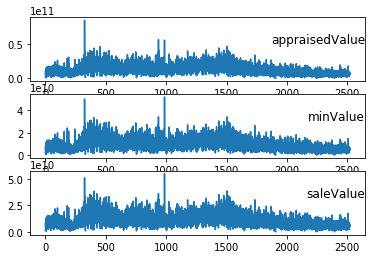

In [21]:
values = dataset.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [22]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

# integer encode direction
#encoder = LabelEncoder()
#values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.020857   0.029146   0.030217  0.136290
2   0.136290   0.161737   0.173351  0.070030
3   0.070030   0.086367   0.092532  0.127192
4   0.127192   0.157105   0.169870  0.178375
5   0.178375   0.215083   0.236830  0.071179


In [15]:
reframed


,var1(t-1),var2(t-1),var3(t-1),var1(t)
1,0.020857,0.018261,0.030217,0.136290
2,0.136290,0.453752,0.173351,0.070030
3,0.070030,0.192140,0.092532,0.127192
4,0.127192,0.437475,0.169870,0.178375
5,0.178375,0.628424,0.236830,0.071179
6,0.071179,0.184597,0.091605,0.145468
7,0.145468,0.510917,0.189029,0.007096
8,0.007096,0.001588,0.008388,0.149383
9,0.149383,0.536324,0.200083,0.109782
10,0.109782,0.339023,0.139892,0.057531


In [23]:
# split into train and test sets
values = reframed.values
n_train_day = 365 * 5
train = values[:n_train_day, :]
test = values[n_train_day:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1825, 1, 3) (1825,) (695, 1, 3) (695,)


Train on 1825 samples, validate on 695 samples
Epoch 1/50
 - 1s - loss: 0.1308 - val_loss: 0.0488
Epoch 2/50
 - 0s - loss: 0.0823 - val_loss: 0.0706
Epoch 3/50
 - 0s - loss: 0.0838 - val_loss: 0.0656
Epoch 4/50
 - 0s - loss: 0.0827 - val_loss: 0.0685
Epoch 5/50
 - 0s - loss: 0.0824 - val_loss: 0.0710
Epoch 6/50
 - 0s - loss: 0.0823 - val_loss: 0.0724
Epoch 7/50
 - 0s - loss: 0.0821 - val_loss: 0.0745
Epoch 8/50
 - 0s - loss: 0.0821 - val_loss: 0.0763
Epoch 9/50
 - 0s - loss: 0.0820 - val_loss: 0.0777
Epoch 10/50
 - 0s - loss: 0.0821 - val_loss: 0.0786
Epoch 11/50
 - 0s - loss: 0.0820 - val_loss: 0.0796
Epoch 12/50
 - 0s - loss: 0.0821 - val_loss: 0.0804
Epoch 13/50
 - 0s - loss: 0.0821 - val_loss: 0.0806
Epoch 14/50
 - 0s - loss: 0.0820 - val_loss: 0.0812
Epoch 15/50
 - 0s - loss: 0.0820 - val_loss: 0.0816
Epoch 16/50
 - 0s - loss: 0.0820 - val_loss: 0.0819
Epoch 17/50
 - 0s - loss: 0.0820 - val_loss: 0.0822
Epoch 18/50
 - 0s - loss: 0.0820 - val_loss: 0.0827
Epoch 19/50
 - 0s - loss: 

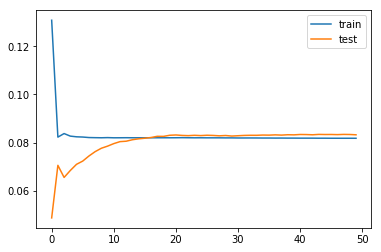

In [24]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [25]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7893614661.374
